## Importing the libraries

In [1]:
import os 
from dotenv import load_dotenv
load_dotenv()

from langgraph.graph import StateGraph , START , END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage
from typing import TypedDict , Annotated
from pydantic import BaseModel , Field

In [2]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [3]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Create first database - about langgraph

In [4]:
urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs

[[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')],
 [Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Workflows & agents', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='\n\n\n\n\n\n\n\n\n\n\n\nWorkflows & agents\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\n            \n            \nThese docs will be deprecated and removed with the release of LangGraph v1.0 in October 2025. Visit the v1.0 alpha docs\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            LangGraph\n          \n\n\n\n            \n              Workflows & agents\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          

In [6]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

# ## Add alll these text to vectordb

# vectorstore=FAISS.from_documents(
#     documents=doc_splits,
#     embedding=OpenAIEmbeddings()
# )


# retriever=vectorstore.as_retriever()

# Save the vectorstore with a particular name, e.g., "bangladesh_economy"
db = Chroma.from_documents(doc_splits, embeddings, persist_directory="langgraph_documents")
langgraph_retriever = db.as_retriever(search_kwargs={"k": 3})

## Creating separate database - about langchain

In [9]:
langchain_urls=[
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]

docs=[WebBaseLoader(url).load() for url in langchain_urls]
docs

[[Document(metadata={'source': 'https://python.langchain.com/docs/tutorials/', 'title': 'Tutorials | 🦜️🔗 LangChain', 'description': 'New to LangChain or LLM app development in general? Read this material to quickly get up and running building your first applications.', 'language': 'en'}, page_content='\n\n\n\n\nTutorials | 🦜️🔗 LangChain\n\n\n\n\n\n\n\n\nSkip to main contentThese docs will be deprecated and no longer maintained with the release of LangChain v1.0 in October 2025. Visit the v1.0 alpha docsIntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engine

In [10]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

# ## Add alll these text to vectordb

# vectorstore=FAISS.from_documents(
#     documents=doc_splits,
#     embedding=OpenAIEmbeddings()
# )


# retriever=vectorstore.as_retriever()

# Save the vectorstore with a particular name, e.g., "bangladesh_economy"
db = Chroma.from_documents(doc_splits, embeddings, persist_directory="langchain_documents")
langchain_retriever = db.as_retriever(search_kwargs={"k": 3})

## create a tool out of both

In [11]:
### Retriever To Retriever Tools
from langchain.tools.retriever import create_retriever_tool

langgraph_retriever_tool=create_retriever_tool(
    langgraph_retriever,
    "retriever_langgraph",
    "Search and run information about Langgraph saved in the documents"
)

In [12]:
from langchain.tools.retriever import create_retriever_tool

langchain_retriever_tool=create_retriever_tool(
    langchain_retriever,
    "retriever_langchain",
    "Search and run information about Langchain saved in the documents"
)

In [13]:
tool_list = [langgraph_retriever_tool , langchain_retriever_tool]

In [14]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Define Nodes

In [15]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    llm_with_tools = model.bind_tools(tool_list)
    response = llm_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [16]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field

In [20]:
### Edges
def grade_documents(state) -> Literal["generate_tool", "rewrite_tool"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM with tool and validation
    grading_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | grading_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate_tool"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite_tool"

In [18]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | model | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [19]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    response = model.invoke(msg)
    return {"messages": [response]}

In [21]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve_tools = ToolNode(tool_list)
workflow.add_node("retrieve", retrieve_tools)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node("generate", generate) 

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    }
)
# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {
        "generate_tool": "generate",
        "rewrite_tool": "rewrite"
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

graph = workflow.compile()



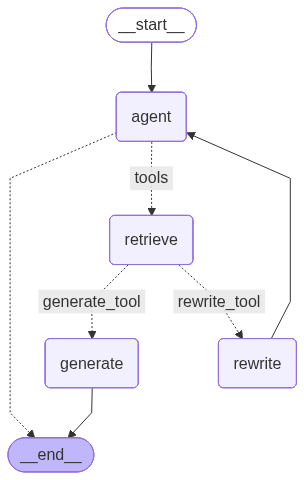

In [22]:
# Compile
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [23]:
graph.invoke({"messages":"What is Langchain?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is Langchain?', additional_kwargs={}, response_metadata={}, id='10e213f3-eb9f-4c4f-91fc-fa02e0aa24c4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OwtwGPODPbAFAjWYRQlXpc9m', 'function': {'arguments': '{"query":"What is Langchain?"}', 'name': 'retriever_langchain'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 102, 'total_tokens': 123, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_95d112f245', 'id': 'chatcmpl-COa7DfL3jQ0jRIZ8vH6hEjwBiRmtg', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4a0af062-62e0-4dd1-aab8-439693ee1100-0', tool_calls=[{'name': 'retriever_langchain', 'args': {'query':

In [24]:
graph.invoke({"messages":"What are the features of Langgraph?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What are the features of Langgraph?', additional_kwargs={}, response_metadata={}, id='9e4b2dd5-e4a9-40b9-bae4-da9ffd028783'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_16JjxWa4LGuDDMJtjtxRaYYu', 'function': {'arguments': '{"query":"features of Langgraph"}', 'name': 'retriever_langgraph'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 105, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_95d112f245', 'id': 'chatcmpl-COa7LKmDLZldg5vqKsafaFaGOCv1j', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3865dfa6-9833-417e-a2cf-17f033433aca-0', tool_calls=[{'name': 'retriever_langgraph

In [25]:
response = graph.invoke({"messages":"What is Langgraph?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


In [26]:
response["messages"][-1].content

'LangGraph is a persistence and workflow management layer that supports features like human-in-the-loop actions, conversational and long-term memory, streaming of outputs, and easy deployment and evaluation. It enables constructing and managing complex agent workflows with capabilities such as interruption, approval, and parallelization of tasks. LangGraph also offers pre-built methods for creating agents and integrating tools programmatically.'